In [26]:
import shap
import torch
import models.simsiam_builder
from dataloader import load_cifar
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np

In [4]:
dim = 512
pred_dim = 128
model = models.simsiam_builder.SimSiam(dim=dim, pred_dim=pred_dim)
model = models.simsiam_builder.SimSiamWrapper(model, dim=dim, num_classes=10)
model.load_state_dict(torch.load("models/fine_tuned_model.pt"))

<All keys matched successfully>

In [5]:
model = model.eval()

In [13]:
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
normalize = transforms.Compose([transforms.ToTensor(), normalize])

In [14]:
dataset = torchvision.datasets.CIFAR10('/files/', train=False, transform=normalize)

In [15]:
len(dataset)

10000

In [16]:
dataset[0]

(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
 
         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],
 
         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863,

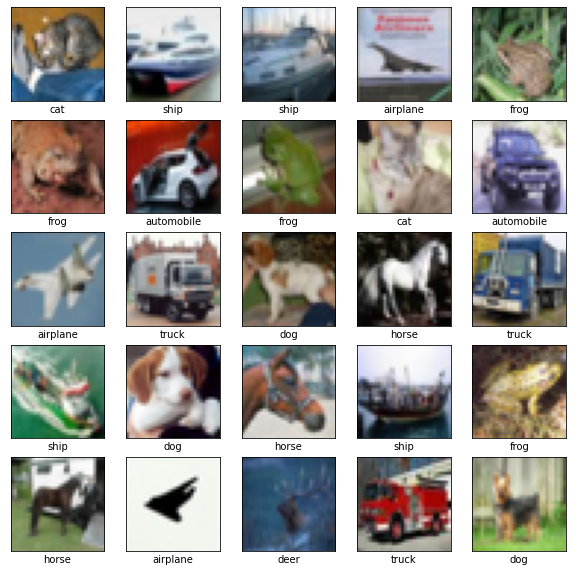

In [29]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def reshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))
    
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(reshow(dataset[i][0]), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[dataset[i][1]])
plt.show()

In [34]:
def split_XY(dataset):

    l = []
    a = torch.Tensor(10000, 3, 32, 32)
    for i, (image, label) in enumerate(dataset):
        a[i, :, :, :] = image
        l.append(label)
    return a, torch.Tensor(l)

X, y = split_XY(dataset)

In [36]:
X.shape

torch.Size([10000, 3, 32, 32])

In [38]:
background = X[np.random.choice(X.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)
test_images = X[100:105]
shap_values= e.shap_values(test_images)

In [41]:
np.shape(shap_values)

(10, 5, 3, 32, 32)

In [42]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

In [44]:
np.shape(shap_numpy)

(10, 5, 32, 32, 3)

In [52]:
test_images_numpy = np.array([reshow(img) for img in test_images])

In [54]:
test_images_numpy.shape

(5, 32, 32, 3)

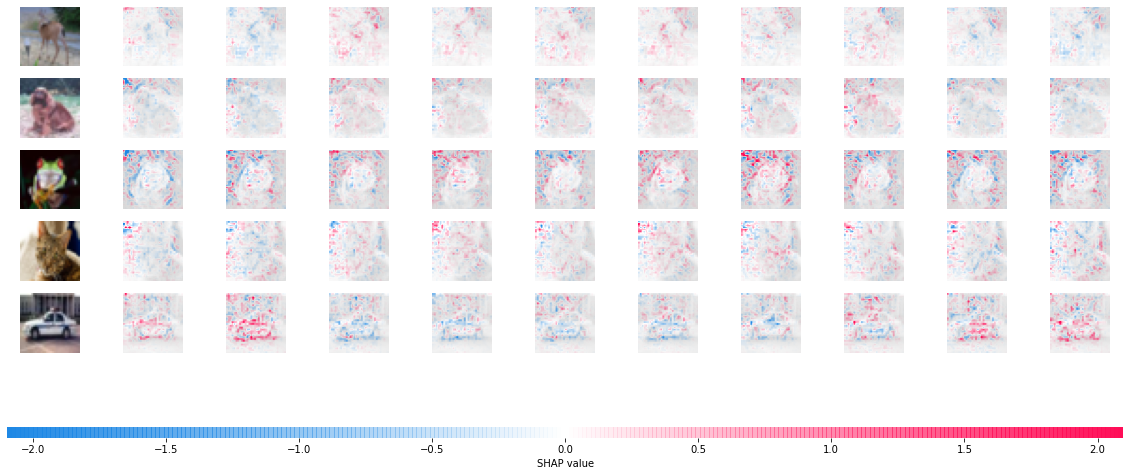

In [58]:
shap.image_plot(shap_numpy, test_images_numpy.reshape(5, 32, 32, 3))